# Let's start a MLP with Keras here

## 1) Libraries

In [99]:
from Classify_Symbols.classify_lib import *

In [100]:
data_base_path = os.path.join(os.pardir, '..\\data')
data_folder = 'lab-03-data'
tar_path = os.path.join(data_base_path, data_folder + '.tar.gz')
with tarfile.open(tar_path, mode='r:gz') as tar:
    tar.extractall(path=data_base_path)

## 2) Load data

In [101]:
image_shape = (28, 28)
train_set_size = 60000
test_set_size = 10000

data_part2_folder = os.path.join(data_base_path, data_folder, 'part2')

train_images_path = os.path.join(data_part2_folder, 'train-images-idx3-ubyte.gz')
train_labels_path = os.path.join(data_part2_folder, 'train-labels-idx1-ubyte.gz')
test_images_path = os.path.join(data_part2_folder, 't10k-images-idx3-ubyte.gz')
test_labels_path = os.path.join(data_part2_folder, 't10k-labels-idx1-ubyte.gz')

train_images = extract_data(train_images_path, image_shape, train_set_size)
test_images = extract_data(test_images_path, image_shape, test_set_size)
train_labels = extract_labels(train_labels_path, train_set_size)
test_labels = extract_labels(test_labels_path, test_set_size)

In [102]:
print(train_images.shape, test_images.shape)
print(train_labels.shape, test_labels.shape)

(60000, 28, 28) (10000, 28, 28)
(60000,) (10000,)


### 2.2) loading pictures as Kilian feeds them to me : will be useful as a test at the end


In [103]:
with open('extractedImgBIG.data', 'rb') as dataFile:  # 1) Load the data
	listObj = pickle.load(dataFile)

SYMBOLS_0 = (STAR_0, EQUAL_0, DIVIDE_0, PLUS_0, MINUS_0) = (0,1,4,7,8)  #to just keep the symbols (and discard the digits)
SYMBOLS = (STAR, EQUAL, DIVIDE, PLUS, MINUS) =  np.arange(len(SYMBOLS_0))
nb_pic = len(listObj) #number of frame with 4 symbols on each
nb_symb = len(SYMBOLS_0)
nb_obj = nb_pic*nb_symb
OFT = 0 #I gonna add 4 times the symbols from moodle (in order to have more often them)

digits = np.zeros( (len(SYMBOLS_0), len(listObj)+OFT, listObj[0][0]['img'].shape[0], listObj[0][0]['img'].shape[1]  ))

for i in np.arange(len(listObj)):
  for j in np.arange(len(SYMBOLS_0)):
    digits[j, i,:,:] = listObj[i][SYMBOLS_0[j]]['img']

In [104]:
digits = digits.reshape( (digits.shape[0]*digits.shape[1],digits.shape[2], digits.shape[3]) ).astype(bool)

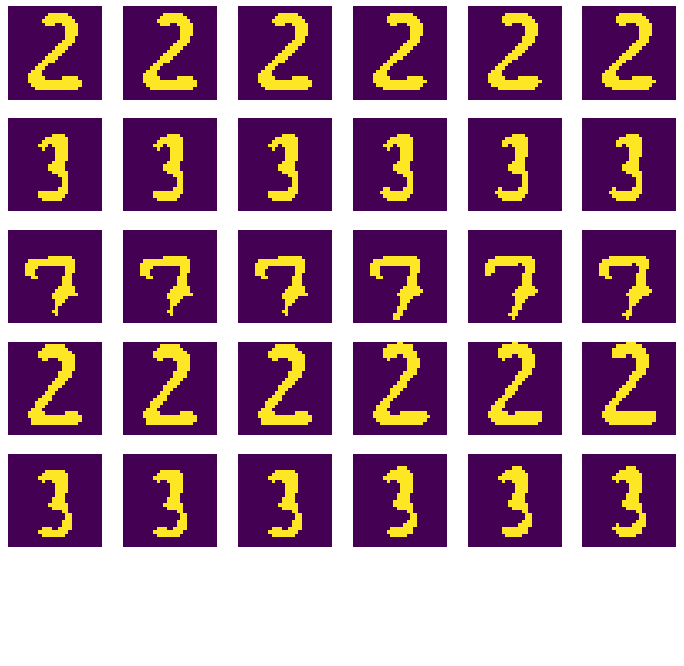

In [105]:
plot_pic( [digits[i,:,:] for i in np.arange(digits.shape[0])], NB_COL =6 )

## 3) Preprocess the data : 
#### 3.1) Remove the 9 labels

In [106]:
nb_data_train, nb_data_test =np.sum(~(train_labels == 9)),  np.sum(~(test_labels==9))
print("real number of train data = {},   real number of test data = {}".format(nb_data_train, nb_data_test))

train_images[0:nb_data_train,:,:] = train_images[~(train_labels == 9)]
test_images[0:nb_data_test,:,:] = test_images[~(test_labels == 9)]
train_labels[0:nb_data_train] = train_labels[~(train_labels == 9)]
test_labels[0:nb_data_test] = test_labels[~(test_labels == 9)]

print("number of 9 in train set = {}         number of 9 in test set = {}".format(
       np.sum(train_labels[0:nb_data_train]==9) , np.sum(test_labels[0:nb_data_test]==9))) #to check there is NO 9 digits

real number of train data = 54051,   real number of test data = 8991
number of 9 in train set = 0         number of 9 in test set = 0


#### 3.2) DATA AUGMENTATION

In [107]:
# for train data
angles = np.random.randint(low = 0, high = 360, size = nb_data_train)       #integers are enough, 1 degree is very small
trans = np.random.uniform(low = -1.5, high = 1.5, size = (nb_data_train,2) )    #float as translation like 1.5 are also useful ! 
# for test data
angles_test = np.random.randint(low = 0, high = 360, size = nb_data_test)   #integers are enough, 1 degree is very small
trans_test = np.random.uniform(low = -1.5, high = 1.5, size = (nb_data_test,2) )#float as translation like 1.5 are also useful ! 

In [108]:
for i in np.arange(nb_data_train):
    T = SimilarityTransform( translation = trans[i] )
    train_images[i,:,:] = rotate(train_images[i,:,:], angles[i])
    train_images[i,:,:] = warp( train_images[i,:,:], inverse_map = T.inverse) 

for i in np.arange(nb_data_test):
    T = SimilarityTransform( translation = trans_test[i] )
    test_images[i,:,:] = rotate(test_images[i,:,:], angles_test[i])
    test_images[i,:,:] = warp( test_images[i,:,:], inverse_map = T.inverse) 
    
print("shapes = {}{}{}{}".format(train_images.shape, test_images.shape, train_labels.shape, test_labels.shape))

shapes = (60000, 28, 28)(10000, 28, 28)(60000,)(10000,)


#### 3.3) Make binary dataset

In [109]:
def compute_global_otsu_treshold(img):
  threshold_global_otsu = threshold_otsu(img)
  return np.copy(img >= threshold_global_otsu)

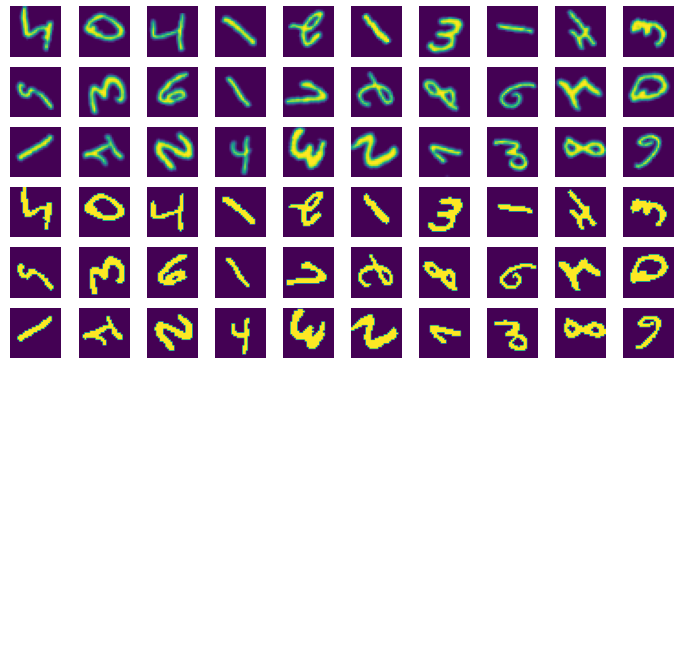

In [110]:
#the treshold seems good ! 
plot_pic( [ *[train_images[i] for i in np.arange(30)],
           *[compute_global_otsu_treshold(train_images[i]) for i in np.arange(30)]] )

In [111]:
for i in np.arange(nb_data_train): # for train dataset 
    train_images[i,:,:] = compute_global_otsu_treshold(train_images[i,:,:])
for i in np.arange(nb_data_test):  # for test dataset
    test_images[i,:,:] = compute_global_otsu_treshold(test_images[i,:,:])
for i in np.arange(digits.shape[0]):  # for Kilian dataset
    digits[i,:,:] = compute_global_otsu_treshold(digits[i,:,:])    

# A first network

In [112]:
# load data
(X_train, y_train), (X_test, y_test) = (train_images, train_labels), (test_images, test_labels)
print("train and test data shape = {}, {},   train and test labels = {}, {}".format( X_train.shape, X_test.shape,y_train.shape, y_test.shape) )

train and test data shape = (60000, 28, 28), (10000, 28, 28),   train and test labels = (60000,), (10000,)


In [113]:
num_pixels = X_train.shape[1]*X_train.shape[2]
#ADJUST TYPE HERE !!!
X_train = X_train.reshape(X_train.shape[0], num_pixels).astype('uint8')
X_test = X_test.reshape(X_test.shape[0], num_pixels).astype('uint8')
digits = digits.reshape(digits.shape[0], num_pixels)
print("Shape of X train, X test, Y train , Y test = {},{},{},{}".format(X_train.shape, X_test.shape,y_train.shape, y_test.shape))

# normalize inputs from 0-255 to 0-1
X_train = X_train # / 255
X_test = X_test   #/ 255
digits = digits

# One hot encode output. In practive, the network returns array of size nb_classes. 
# So for instance it doesn't return '3' but [0, 0, 0, 1, 0, 0, 0, 0, 0] instead
y_train = np_utils.to_categorical(y_train)
y_test = np_utils.to_categorical(y_test)
num_classes = y_test.shape[1]

Shape of X train, X test, Y train , Y test = (60000, 784),(10000, 784),(60000,),(10000,)


In [116]:
X_train.shape

(60000, 784)

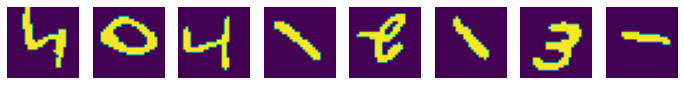

In [119]:
plot_pic( [X_train[i,:].reshape(28,28) for i in np.arange(8)] )

In [120]:
np.amax(X_train[0])

1

In [170]:
# define baseline model
def FCN():
    # create model
    model = Sequential()
    model.add(Dense(num_pixels, input_dim=num_pixels, kernel_initializer='normal', activation='relu',
                   kernel_regularizer=keras.regularizers.l1_l2(l1=0.00, l2=0.00) ))
    #model.add(Dense(int(num_pixels/4), input_dim=num_pixels, kernel_initializer='normal', activation='relu',
    #               kernel_regularizer=keras.regularizers.l1_l2(l1=0.00, l2=0.01)   ))
    model.add(Dense(num_classes, kernel_initializer='normal', activation='softmax',
                   kernel_regularizer=keras.regularizers.l1_l2(l1=0.00, l2=0.00) ))
    # Compile model
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model

In [171]:
model = FCN()
#model.summary() #show the current structure of the network

h = model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=40, batch_size=200, verbose=2) # Fit the model

scores = model.evaluate(X_test, y_test, verbose=0) # Final evaluation of the model
print("Baseline Error: %.2f%%" % (100-scores[1]*100))

Train on 60000 samples, validate on 10000 samples
Epoch 1/40
 - 5s - loss: 2.0266 - acc: 0.4703 - val_loss: 1.6501 - val_acc: 0.5340
Epoch 2/40
 - 4s - loss: 1.5306 - acc: 0.5944 - val_loss: 1.4709 - val_acc: 0.6300
Epoch 3/40
 - 4s - loss: 1.2632 - acc: 0.6754 - val_loss: 1.2269 - val_acc: 0.6941
Epoch 4/40
 - 4s - loss: 1.1887 - acc: 0.6979 - val_loss: 1.2574 - val_acc: 0.6940
Epoch 5/40
 - 4s - loss: 1.1409 - acc: 0.7108 - val_loss: 1.0215 - val_acc: 0.7519
Epoch 6/40
 - 4s - loss: 0.9842 - acc: 0.7574 - val_loss: 0.9526 - val_acc: 0.7697
Epoch 7/40
 - 4s - loss: 0.9572 - acc: 0.7704 - val_loss: 0.9857 - val_acc: 0.7548
Epoch 8/40
 - 5s - loss: 0.9269 - acc: 0.7759 - val_loss: 0.9165 - val_acc: 0.7799
Epoch 9/40
 - 4s - loss: 0.9002 - acc: 0.7876 - val_loss: 0.9506 - val_acc: 0.7872
Epoch 10/40
 - 4s - loss: 0.7952 - acc: 0.8180 - val_loss: 1.0621 - val_acc: 0.7382
Epoch 11/40
 - 4s - loss: 0.7900 - acc: 0.8204 - val_loss: 0.8636 - val_acc: 0.8037
Epoch 12/40
 - 4s - loss: 0.7807 - 

dict_keys(['val_loss', 'val_acc', 'loss', 'acc'])


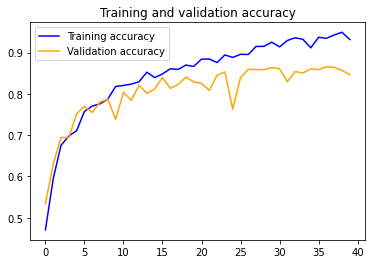

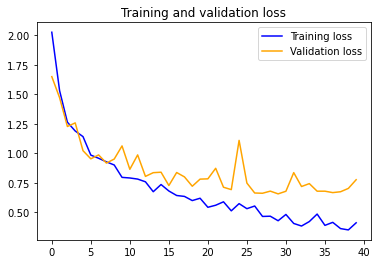

In [173]:
print(h.history.keys())
accuracy = h.history['acc']
val_accuracy = h.history['val_acc']
loss = h.history['loss']
val_loss = h.history['val_loss']
epochs = range(len(accuracy))
plt.plot(epochs, accuracy, 'blue', label='Training accuracy')
plt.plot(epochs, val_accuracy, 'orange', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend()
plt.show()
plt.figure()
plt.plot(epochs, loss, 'blue', label='Training loss')
plt.plot(epochs, val_loss, 'orange', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()

### test from kilian pictures :

In [174]:
groundtruth = np.array([  *[2]*6, *[3]*6, *[7]*6, *[2]*6, *[3]*6 ])
pred = np.zeros( groundtruth.shape )
for idx, i in enumerate(model.predict(digits)):
  the_idx = np.where(i == np.amax(i))
  pred[idx] = the_idx[0]
print("nb_error with kilian dataset = ", np.sum(~(pred==groundtruth)))

nb_error with kilian dataset =  0


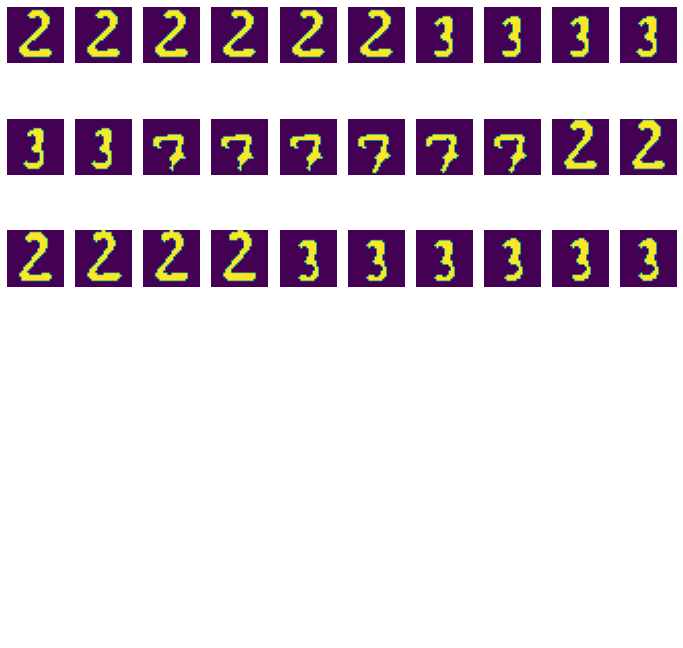

In [176]:
plot_pic( [digits[i,:].reshape(28,28) for i in np.arange(30)] )

# ============================================================
# ======    NOTHING INTERESTING HERE FOR NOW !!!

# ============================================================
## CNN first try
# ============================================================

In [68]:
def resnet_layer(inputs,
                 num_filters=16,
                 kernel_size=3,                
                 strides=1,
                 activation='relu',
                 batch_normalization=True,
                 conv_first=True):
    """2D Convolution-Batch Normalization-Activation stack builder

    # Arguments
        inputs (tensor): input tensor from input image or previous layer
        num_filters (int): Conv2D number of filters
        kernel_size (int): Conv2D square kernel dimensions
        strides (int): Conv2D square stride dimensions
        activation (string): activation function (relu, sigmoid, etc.)
        batch_normalization (bool): whether to include batch normalization
        conv_first (bool): conv-bn-activation (True) or
            bn-activation-conv (False)

    # Returns
        x (tensor): tensor as input to the next layer
    """
    conv = Conv2D(num_filters,
                  kernel_size=kernel_size,
                  strides=strides,
                  padding='same',
                  kernel_initializer='he_normal',
                  kernel_regularizer=l2(1e-4))

    x = inputs
    #2 possibilities : 
    # 1) First convolute, then normalize
    # 2) First normalize, then convolute
    if conv_first:
        x = conv(x)
        if batch_normalization:
            x = BatchNormalization()(x)
        if activation is not None:
            x = Activation(activation)(x)
    else:
        if batch_normalization:
            x = BatchNormalization()(x)
        if activation is not None:
            x = Activation(activation)(x)
        x = conv(x)
    return x

In [80]:
def residual_block(inputs, nb_filters_out = 32 , activation = 'relu', batch_normalization = 'true', kernel_size = 5):
    """Residual_block

    # Arguments
        input_shape (tensor): shape of input image tensor
        depth (int): number of core convolutional layers

    # Returns
        model (Model): Keras model instance
    """
    
    #Need to remove this from here later
    strides = 1
    kernel_size_res = 1
    
    # x = residual of the block
    x = resnet_layer(inputs=inputs,
                     num_filters=nb_filters_out,
                     kernel_size=kernel_size_res,
                     strides=strides,
                     activation=None,
                     batch_normalization=batch_normalization,
                     conv_first=False)
    
    # y = picture we transform in the block
    y = resnet_layer(inputs=inputs,
                     num_filters=nb_filters_out,
                     kernel_size=kernel_size,
                     strides=strides,
                     activation=activation,
                     batch_normalization=batch_normalization,
                     conv_first=True)
    y = resnet_layer(inputs=y,
                     num_filters=nb_filters_out,
                     kernel_size=kernel_size,
                     strides=strides,
                     activation=activation,
                     batch_normalization=batch_normalization,
                     conv_first=True)
    y = resnet_layer(inputs=y,
                     num_filters=nb_filters_out,
                     kernel_size=kernel_size,
                     strides=strides,
                     activation=None,
                     batch_normalization=batch_normalization,
                     conv_first=True)
    
    x = keras.layers.add([x, y])
    x = resnet_layer(inputs = x,          
                    num_filters = nb_filters_out, #For now, the whole block will end up with nb_filters_out filters
                    kernel_size = kernel_size,
                    strides = strides,
                    activation = activation, #Before : None
                    batch_normalization = False)

    return x 
    
    #Instatiate model : 
    #model = Model(inputs=inputs, outputs=x)
    #return model


In [70]:
def complete_resnet_resnet(input_shape, depth):
    """Residual_block

    # Arguments
        input_shape (tensor): shape of input image tensor
        depth (int): number of core convolutional layers

    # Returns
        model (Model): Keras model instance
        
    Stucture :
    
    inputs --> RESNET (regression) --> x --> RESNET (classification) --> y
    outputs = [x,y]
        
    """
    
    activation = 'relu'
    batch_normalization = True
    strides = 1
    my_kernel_size = 5                      # I CHANGED TO 5
    
   
    #filters = [16, 24, 24, 32, 32, 24, 24, 16, 1]  #As in the papers
    filters = [24, 32, 32, 32, 32, 32, 32, 24, 1] #a test ----- struct2
    #filters = [16, 16, 24, 24, 24, 24, 32, 32, 24, 24, 16, 16, 1] #Try1
    
    # inputs = original picture entry
    x = inputs = Input(shape=input_shape)
    
    # -------------- RESNET (regression) --------------------
    #apply a sequence of residual networks 
    for fil in filters:
      x = residual_block(x, nb_filters_out = fil, kernel_size= my_kernel_size)
      
    # -------------- RESNET (classification )-----------------
    filters_K = filters #same as the first prediction part
    y = x #we keep the output of the first ResNet into x
    
    for fil in filters_K:
      y = residual_block(y, nb_filters_out = fil, kernel_size= my_kernel_size)
    y = Dense(K, activation='softmax', kernel_initializer='he_normal')(y) #K = nb_class
    
    #Instantiate the model
    model = Model(inputs=inputs, outputs=[x,y])
    return model

In [78]:
from keras.layers import Dense, Conv2D, BatchNormalization, Activation
from keras.layers import AveragePooling2D, Input, Flatten
from keras.optimizers import Adam
from keras.callbacks import ModelCheckpoint, LearningRateScheduler
from keras.callbacks import ReduceLROnPlateau
from keras.regularizers import l2
from keras import backend as K
from keras.models import Model

In [87]:
the_input_shape = (28,28,1)
the_inputs = Input(shape=the_input_shape)
output1 = residual_block( the_inputs, nb_filters_out = 24, kernel_size = 5 )

model = Model(inputs=the_inputs, outputs= output1)

In [88]:
h = model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=5, batch_size=200, verbose=2)
# Final evaluation of the model
scores = model.evaluate(X_test, y_test, verbose=0)
print("Baseline Error: %.2f%%" % (100-scores[1]*100))

RuntimeError: You must compile a model before training/testing. Use `model.compile(optimizer, loss)`.

In [79]:
# ======================  see later that

model = complete_resnet_resnet( (28, 28, 1), 56 )
#model.summary() #show the current structure of the network


# Fit the model
h = model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=5, batch_size=200, verbose=2)
# Final evaluation of the model
scores = model.evaluate(X_test, y_test, verbose=0)
print("Baseline Error: %.2f%%" % (100-scores[1]*100))


TypeError: Failed to convert object of type <class 'tuple'> to Tensor. Contents: (1, <module 'keras.backend' from 'C:\\Users\\etaxi\\Anaconda3\\envs\\keras-gpu\\lib\\site-packages\\keras\\backend\\__init__.py'>). Consider casting elements to a supported type.

# Let's start over here

In [ ]:
CNN_input_shape = (28,28,1)
CNN_inputs = Input(shape=CNN_input_shape)

# start building the CNN structure 
strides = 1
kernel_size_res = 1
nb_filters_out = 32
batch_normalization = False

# x = residual of the block
x = resnet_layer(inputs=CNN_inputs,
                 num_filters=nb_filters_out,
                 kernel_size=kernel_size_res,
                 strides=strides,
                 activation=None,
                 batch_normalization=batch_normalization,
                 conv_first=False)

# y = picture we transform in the block
y = resnet_layer(inputs=CNN_inputs,
                 num_filters=nb_filters_out,
                 kernel_size=kernel_size,
                 strides=strides,
                 activation=activation,
                 batch_normalization=batch_normalization,
                 conv_first=True)
y = resnet_layer(inputs=y,
                 num_filters=nb_filters_out,
                 kernel_size=kernel_size,
                 strides=strides,
                 activation=activation,
                 batch_normalization=batch_normalization,
                 conv_first=True)
y = resnet_layer(inputs=y,
                 num_filters=nb_filters_out,
                 kernel_size=kernel_size,
                 strides=strides,
                 activation=None,
                 batch_normalization=batch_normalization,
                 conv_first=True)

x = keras.layers.add([x, y])
x = resnet_layer(inputs = x,          
                num_filters = nb_filters_out, #For now, the whole block will end up with nb_filters_out filters
                kernel_size = kernel_size,
                strides = strides,
                activation = activation, #Before : None
                batch_normalization = False)
x = 




# end of CNN structure
output1 = residual_block( the_inputs, nb_filters_out = 24, kernel_size = 5 )

model = Model(inputs=the_inputs, outputs= output1)

In [ ]:
def residual_block(inputs, nb_filters_out = 32 , activation = 'relu', batch_normalization = 'true', kernel_size = 5):
    """Residual_block

    # Arguments
        input_shape (tensor): shape of input image tensor
        depth (int): number of core convolutional layers

    # Returns
        model (Model): Keras model instance
    """
    
    #Need to remove this from here later
    strides = 1
    kernel_size_res = 1
    
    # x = residual of the block
    x = resnet_layer(inputs=inputs,
                     num_filters=nb_filters_out,
                     kernel_size=kernel_size_res,
                     strides=strides,
                     activation=None,
                     batch_normalization=batch_normalization,
                     conv_first=False)
    
    # y = picture we transform in the block
    y = resnet_layer(inputs=inputs,
                     num_filters=nb_filters_out,
                     kernel_size=kernel_size,
                     strides=strides,
                     activation=activation,
                     batch_normalization=batch_normalization,
                     conv_first=True)
    y = resnet_layer(inputs=y,
                     num_filters=nb_filters_out,
                     kernel_size=kernel_size,
                     strides=strides,
                     activation=activation,
                     batch_normalization=batch_normalization,
                     conv_first=True)
    y = resnet_layer(inputs=y,
                     num_filters=nb_filters_out,
                     kernel_size=kernel_size,
                     strides=strides,
                     activation=None,
                     batch_normalization=batch_normalization,
                     conv_first=True)
    
    x = keras.layers.add([x, y])
    x = resnet_layer(inputs = x,          
                    num_filters = nb_filters_out, #For now, the whole block will end up with nb_filters_out filters
                    kernel_size = kernel_size,
                    strides = strides,
                    activation = activation, #Before : None
                    batch_normalization = False)

    return x 
    
    #Instatiate model : 
    #model = Model(inputs=inputs, outputs=x)
    #return model
